# Segmentez des clients d'un site e-commerce


## Notebook de simulation

#### Le modèle séléctionné est celui du KMeans avec 5 clusters. Je vais maintenant simuler le passage du temps et calculer le score de Rand pour savoir quand renouveler l'entrainement.

J'importe les librairies nécessaires.

In [2]:
import pandas as pd 
from sklearn.preprocessing import StandardScaler 
from sklearn import cluster, metrics
import matplotlib.pyplot as plt 
from sklearn.metrics.cluster import adjusted_rand_score
from datetime import datetime
from datetime import timedelta
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import numpy as np

# <a name="C2"> Travail de maintenance</a>

J'importe mes données. Je vais utiliser le dataframe concernant les commandes, que je vais trier dans l'ordre croissant par rapport aux dates de commandes.

In [3]:
data1 = pd.read_csv("olist_orders_dataset.csv")
data1 = data1.sort_values("order_purchase_timestamp")
data1 = pd.DataFrame(data1)
data1.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
4541,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,NaN,2016-10-20 00:00:00
4396,e5fa5a7210941f7d56d0208e4e071d35,683c54fc24d40ee9f8a6fc179fd9856c,canceled,2016-09-05 00:15:34,2016-10-07 13:17:15,NaN,NaN,2016-10-28 00:00:00
10071,809a282bbd5dbcabb6f2f724fca862ec,622e13439d6b5a0b486c435618b2679e,canceled,2016-09-13 15:24:19,2016-10-07 13:16:46,NaN,NaN,2016-09-30 00:00:00
30710,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00
83078,71303d7e93b399f5bcd537d124c0bcfa,b106b360fe2ef8849fbbd056f777b4d5,canceled,2016-10-02 22:07:52,2016-10-06 15:50:56,NaN,NaN,2016-10-25 00:00:00


La dernière commande à été enregistrée le 17/10/2018. Je décide de définir T0, la période de référence qui est comprise entre la date de la première commande jusqu'à un an avant la denrière commande. Donc T0 est compris entre le 04/09/2016 et le 17/10/2018.

In [4]:
data1 = data1.loc[(data1["order_purchase_timestamp"]) <= "2017-10-17"]

J'importe ensuite les autres dataframe dont j'ai besoin et je les fusionne à data1 puis je garde les colonnes qui m'intéressent.

In [5]:
data2 = pd.read_csv("olist_customers_dataset.csv")
data3 = pd.read_csv("olist_order_items_dataset.csv")
data4 = pd.read_csv("olist_order_reviews_dataset.csv")
data = pd.merge(data1, data2, on = "customer_id")
data = pd.merge(data, data3, on = "order_id")
data = pd.merge(data, data4, on = "order_id")
data = data.loc[:, ["customer_unique_id", "order_purchase_timestamp", "price", "review_score"]]
data.head()

,customer_unique_id,order_purchase_timestamp,price,review_score
0,b7d76e111c89f7ebf14761390f0f7d17,2016-09-04 21:15:19,39.99,1
1,b7d76e111c89f7ebf14761390f0f7d17,2016-09-04 21:15:19,32.90,1
2,4854e9b3feff728c13ee5fc7d1547e92,2016-09-05 00:15:34,59.50,1
3,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09-15 12:16:38,44.99,1
4,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09-15 12:16:38,44.99,1


J'agrège mes données.

In [6]:
data = data.groupby("customer_unique_id").agg({"order_purchase_timestamp" : "max", "customer_unique_id" : "count",
                                               "price": "sum", "review_score" : "mean"})

data.rename(columns = {"price":"Monetary", "order_purchase_timestamp" : "Recency", "customer_unique_id" : "Frequency",
                       "review_score" : "Average_review_score"}, inplace = True)
data.head()

,Recency,Frequency,Monetary,Average_review_score
customer_unique_id,,,,
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1,69.00,3.0
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1,25.99,4.0
0005e1862207bf6ccc02e4228effd9a0,2017-03-04 23:32:12,1,135.00,4.0
0006fdc98a402fceb4eb0ee528f6a8d4,2017-07-18 09:23:10,1,13.90,3.0
000a5ad9c4601d2bbdd9ed765d5213b3,2017-08-11 13:45:15,1,76.99,4.0


In [7]:
data["Recency"] = pd.to_datetime(data["Recency"])

Je réalise mon feature engineering.

In [8]:
date = datetime.now()
date = pd.to_datetime(date)
data["Recency"] = (date - data["Recency"]).dt.days
data["Average_shopping_basket"] = data["Monetary"] / data["Frequency"]
data.head()

,Recency,Frequency,Monetary,Average_review_score,Average_shopping_basket
customer_unique_id,,,,,
0000f46a3911fa3c0805444483337064,2150,1,69.00,3.0,69.00
0000f6ccb0745a6a4b88665a16c9f078,1934,1,25.99,4.0,25.99
0005e1862207bf6ccc02e4228effd9a0,2156,1,135.00,4.0,135.00
0006fdc98a402fceb4eb0ee528f6a8d4,2021,1,13.90,3.0,13.90
000a5ad9c4601d2bbdd9ed765d5213b3,1997,1,76.99,4.0,76.99


J'ai mon premier dataframe que je renomme T0, car c'est ma première période de référence. Je fais un scaler de référence que je fit sur T0. Puis j'applique mon modèle sur T0 scalé.

In [9]:
T0 = data
km = KMeans(5)
scaler = StandardScaler()

scaler_ref = scaler.fit(T0)
T0_scaled = scaler_ref.transform(T0)
km0 = km.fit(T0_scaled)

Je vais créer une fonction qui regroupe les étapes que j'ai réalisée pour trouver mon dataframe T0.

In [10]:
def creation(date):
    data1 = pd.read_csv("olist_orders_dataset.csv")
    data1 = data1.loc[(data1["order_purchase_timestamp"]) <= date]
    data2 = pd.read_csv("olist_customers_dataset.csv")
    data3 = pd.read_csv("olist_order_items_dataset.csv")
    data4 = pd.read_csv("olist_order_reviews_dataset.csv")
    data = pd.merge(data1, data2, on = "customer_id")
    data = pd.merge(data, data3, on = "order_id")
    data = pd.merge(data, data4, on = "order_id")
    data = data.loc[:, ["customer_unique_id", "order_purchase_timestamp", "price", "review_score"]]
    data = data.groupby("customer_unique_id").agg({"order_purchase_timestamp" : "max", "customer_unique_id" : "count",
                                               "price": "sum", "review_score" : "mean"})

    data.rename(columns = {"price":"Monetary", "order_purchase_timestamp" : "Recency", "customer_unique_id" : "Frequency",
                       "review_score" : "Average_review_score"}, inplace = True)
    data["Recency"] = pd.to_datetime(data["Recency"])
    date = datetime.now()
    date = pd.to_datetime(date)
    data["Recency"] = (date - data["Recency"]).dt.days
    data["Average_shopping_basket"] = data["Monetary"] / data["Frequency"]
    
    return data   

Je réalise une boucle qui s'arrêtera lorsque l'ARI sera inférieur à 0.8 (score acceptable).
Je vais créer plusieurs dataframe grâce à mon fonction "creation" avec un pas de 1 semaine.
J'affiche l'ARI correspondant à chaque date.

In [11]:
ARI = adjusted_rand_score(km0.predict(T0_scaled), km0.predict(T0_scaled))
print("ARI à T0 : ", ARI)
date = datetime(2017,10,17)
lst = [ARI]

while ARI >= 0.8:
    date += timedelta(weeks = 1)
    date_str = date.strftime('%Y-%m-%d')
    print ("\nDate : ", date_str)
    T = creation(date_str)
    km = KMeans(5)
    scaler = StandardScaler()
    T_scaled = scaler.fit_transform(T)
    km = km.fit(T_scaled)
    ARI = adjusted_rand_score(km0.predict(scaler_ref.transform(T)), km.predict(T_scaled))
    lst = lst + [ARI]
    print("ARI: ", ARI)  

ARI à T0 :  1.0

Date :  2017-10-24
ARI:  0.9526266595094404

Date :  2017-10-31
ARI:  0.9291366218318539

Date :  2017-11-07
ARI:  0.9062743829592698

Date :  2017-11-14
ARI:  0.8762713215692884

Date :  2017-11-21
ARI:  0.8417804623495899

Date :  2017-11-28
ARI:  0.7640682844130908


J'affiche la courbe représentant l'évolution des scores ainsi que la courbe qui représente le score acceptable, à savoir y = 0.8.

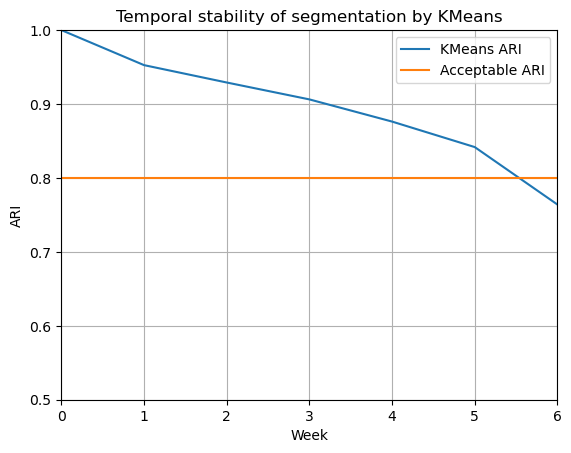

In [12]:
plt.plot([0, 1, 2, 3, 4, 5, 6], lst , label = "KMeans ARI")
plt.plot([0, 1, 2, 3, 4, 5, 6], [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8], label = "Acceptable ARI")
plt.legend()
plt.axis([0, 6, 0.5, 1])
plt.title("Temporal stability of segmentation by KMeans")
plt.xlabel("Week")
plt.ylabel("ARI")
plt.grid()
plt.show()

D'après le graph, on remarque que le modèle doit être réentraîné tous les 6 semaines environ.